# RQ5: Evaluative tone by document type and over time

This notebook analyses how evaluative tone differs between motioner (MP proposals) and propositioner (government bills), and how sentiment has changed over parliamentary years.

## Setup and imports

In [1]:
import re
from pathlib import Path
from collections import defaultdict

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from bs4 import BeautifulSoup
from scipy import stats

In [2]:
# visualisation settings
plt.rcParams['font.family'] = 'monospace'
plt.rcParams['font.size'] = 10
plt.rcParams['axes.labelsize'] = 10
plt.rcParams['axes.titlesize'] = 11
plt.rcParams['xtick.labelsize'] = 9
plt.rcParams['ytick.labelsize'] = 9
plt.rcParams['legend.fontsize'] = 9

# purple/pink colour palette
COLOUR_MOT = '#9B59B6'  # purple
COLOUR_PROP = '#E91E63'  # pink
COLOUR_PALETTE = [COLOUR_MOT, COLOUR_PROP]

## Data loading

In [3]:
def parse_document(file_path):
    """extract metadata and content from document file."""
    with open(file_path, 'r', encoding='utf-8') as f:
        content = f.read()
    
    # split metadata from content
    parts = content.split('=' * 80, 1)
    if len(parts) != 2:
        return None
    
    metadata_section, html_content = parts
    
    # extract metadata fields
    metadata = {}
    for line in metadata_section.strip().split('\n'):
        if ':' in line:
            key, value = line.split(':', 1)
            metadata[key.strip()] = value.strip()
    
    # extract plain text from html
    soup = BeautifulSoup(html_content, 'html.parser')
    text = soup.get_text(separator=' ', strip=True)
    
    return {
        'doc_id': metadata.get('DOCUMENT ID', ''),
        'title': metadata.get('TITLE', ''),
        'date': metadata.get('DATE', ''),
        'parl_year': metadata.get('PARLIAMENTARY YEAR', ''),
        'text': text
    }

In [4]:
# load motioner
data_dir = Path('/Users/simon/Dropbox/wrk/active/research/riksdagen-data/swe-rd-ai/data')
motioner_dir = data_dir / 'motioner'
propositioner_dir = data_dir / 'propositioner'

documents = []

# load motioner
for file_path in motioner_dir.glob('*.txt'):
    doc = parse_document(file_path)
    if doc:
        doc['doc_type'] = 'mot'
        documents.append(doc)

# load propositioner
for file_path in propositioner_dir.glob('*.txt'):
    doc = parse_document(file_path)
    if doc:
        doc['doc_type'] = 'prop'
        documents.append(doc)

df = pd.DataFrame(documents)
print(f"loaded {len(df)} documents")
print(f"  motioner: {len(df[df['doc_type'] == 'mot'])}")
print(f"  propositioner: {len(df[df['doc_type'] == 'prop'])}")

loaded 1152 documents
  motioner: 452
  propositioner: 700


## Context extraction

In [5]:
# ai search patterns
ai_patterns = [
    r'\bai\b',
    r'artificiell intelligens',
    r'maskininlärning',
    r'maskinlärning',
    r'djupinlärning',
    r'deep learning',
    r'machine learning'
]

ai_regex = re.compile('|'.join(ai_patterns), re.IGNORECASE)

In [6]:
def extract_ai_contexts(text, window=100):
    """extract text windows around ai mentions."""
    contexts = []
    
    for match in ai_regex.finditer(text):
        start = max(0, match.start() - window)
        end = min(len(text), match.end() + window)
        context = text[start:end]
        contexts.append(context)
    
    return contexts

In [7]:
# extract contexts for all documents
df['ai_contexts'] = df['text'].apply(extract_ai_contexts)
df['context_count'] = df['ai_contexts'].apply(len)
df['combined_context'] = df['ai_contexts'].apply(lambda x: ' '.join(x).lower())

print(f"total ai mentions: {df['context_count'].sum()}")
print(f"documents with ai mentions: {len(df[df['context_count'] > 0])}")

total ai mentions: 4564
documents with ai mentions: 705


## Swedish sentiment lexicons

In [8]:
# positive word list
positive_words = [
    'bra', 'positiv', 'möjlighet', 'möjligheter', 'framgång', 'effektiv', 
    'förbättra', 'förbättring', 'utveckla', 'utveckling', 'framsteg', 
    'fördelar', 'fördel', 'potential', 'styrka', 'lovande', 'framtid',
    'nytta', 'gynnsam', 'värdefull', 'innovation', 'innovativ',
    'produktiv', 'produktivitet', 'konkurrenskraft', 'konkurrenskraftig'
]

# negative word list
negative_words = [
    'problem', 'risk', 'risker', 'hot', 'oro', 'svårt', 'svårighet',
    'utmaning', 'utmaningar', 'nackdel', 'nackdelar', 'brist', 'brister',
    'hinder', 'fara', 'faror', 'missbruk', 'kris', 'sårbar', 'sårbarhet',
    'negativ', 'negativa', 'osäkerhet', 'konflikt', 'bekymmer'
]

print(f"positive words: {len(positive_words)}")
print(f"negative words: {len(negative_words)}")

positive words: 26
negative words: 25


## Sentiment scoring

In [9]:
def count_sentiment_words(text, word_list):
    """count occurrences of words from word_list in text."""
    count = 0
    for word in word_list:
        # word boundary matching
        pattern = r'\b' + re.escape(word) + r'\b'
        count += len(re.findall(pattern, text, re.IGNORECASE))
    return count

In [10]:
# calculate sentiment scores
df['positive_count'] = df['combined_context'].apply(
    lambda x: count_sentiment_words(x, positive_words)
)
df['negative_count'] = df['combined_context'].apply(
    lambda x: count_sentiment_words(x, negative_words)
)

# calculate sentiment ratio normalised by context length
df['context_length'] = df['combined_context'].apply(len)
df['sentiment_ratio'] = (df['positive_count'] - df['negative_count']) / (df['context_length'] + 1) * 1000

# filter to documents with ai mentions
df_with_ai = df[df['context_count'] > 0].copy()

print(f"documents with ai mentions: {len(df_with_ai)}")
print(f"\nsentiment statistics:")
print(df_with_ai[['positive_count', 'negative_count', 'sentiment_ratio']].describe())

documents with ai mentions: 705

sentiment statistics:
       positive_count  negative_count  sentiment_ratio
count      705.000000      705.000000       705.000000
mean         2.188652        0.802837         1.033787
std          6.470421        2.608878         2.580094
min          0.000000        0.000000        -4.926108
25%          0.000000        0.000000         0.000000
50%          0.000000        0.000000         0.000000
75%          2.000000        0.000000         1.642036
max        102.000000       35.000000        14.778325


## Temporal sentiment analysis

In [11]:
# clean parliamentary year format
df_with_ai['year_clean'] = df_with_ai['parl_year'].str.split('/').str[0]
df_with_ai['year_clean'] = pd.to_numeric(df_with_ai['year_clean'], errors='coerce')

# filter valid years
df_temporal = df_with_ai[df_with_ai['year_clean'].notna()].copy()

# group by year and document type
temporal_sentiment = df_temporal.groupby(['year_clean', 'doc_type']).agg({
    'sentiment_ratio': 'mean',
    'doc_id': 'count'
}).reset_index()
temporal_sentiment.columns = ['year', 'doc_type', 'mean_sentiment', 'doc_count']

temporal_sentiment.head(10)

,year,doc_type,mean_sentiment,doc_count
0,1989,mot,1.172883,7
1,1989,prop,-0.328407,5
2,1990,mot,-0.615764,2
3,1990,prop,-0.410509,4
4,1991,mot,0.000000,1
5,1991,prop,0.042103,9
6,1992,mot,0.000000,1
7,1992,prop,-0.250867,9
8,1993,prop,0.000000,3
9,1994,mot,2.463054,2


## Visualisations

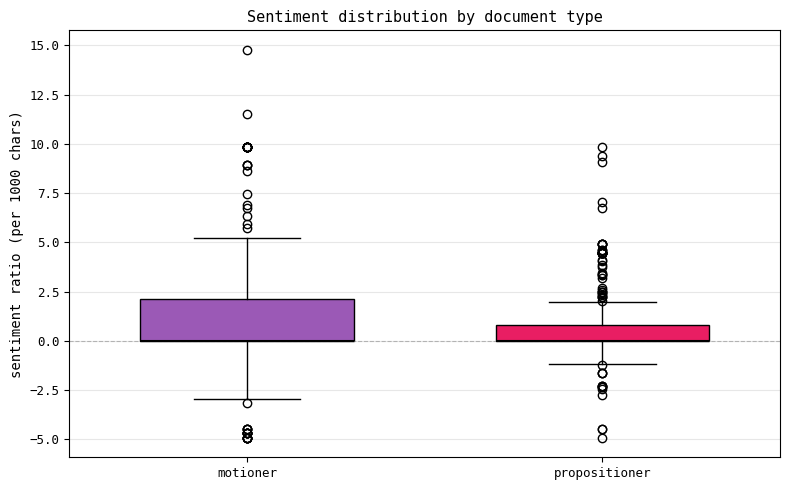

In [12]:
# box plot comparing sentiment distributions by document type
fig, ax = plt.subplots(figsize=(8, 5))

mot_data = df_with_ai[df_with_ai['doc_type'] == 'mot']['sentiment_ratio']
prop_data = df_with_ai[df_with_ai['doc_type'] == 'prop']['sentiment_ratio']

positions = [1, 2]
bp = ax.boxplot(
    [mot_data, prop_data],
    positions=positions,
    widths=0.6,
    patch_artist=True,
    medianprops={'color': 'black', 'linewidth': 1.5},
    boxprops={'facecolor': 'lightgrey', 'edgecolor': 'black'},
    whiskerprops={'color': 'black'},
    capprops={'color': 'black'}
)

# colour boxes
bp['boxes'][0].set_facecolor(COLOUR_MOT)
bp['boxes'][1].set_facecolor(COLOUR_PROP)

ax.set_xticks(positions)
ax.set_xticklabels(['motioner', 'propositioner'])
ax.set_ylabel('sentiment ratio (per 1000 chars)')
ax.set_title('Sentiment distribution by document type')
ax.axhline(y=0, color='grey', linestyle='--', linewidth=0.8, alpha=0.5)
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('/Users/simon/Dropbox/wrk/active/research/riksdagen-data/swe-rd-ai/results/rq5_sentiment_boxplot.png', 
            dpi=300, bbox_inches='tight')
plt.show()

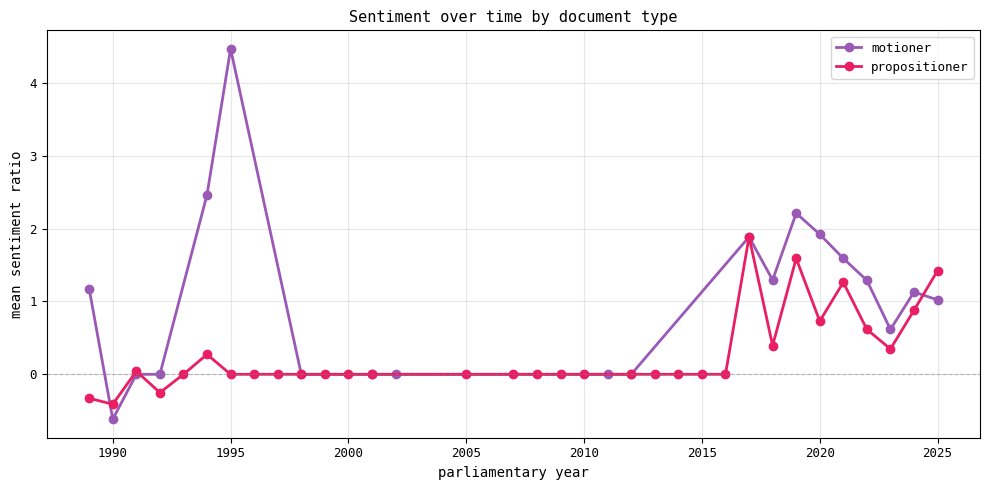

In [13]:
# line chart of sentiment over time by type
fig, ax = plt.subplots(figsize=(10, 5))

for doc_type, colour in [('mot', COLOUR_MOT), ('prop', COLOUR_PROP)]:
    data = temporal_sentiment[temporal_sentiment['doc_type'] == doc_type]
    ax.plot(data['year'], data['mean_sentiment'], 
            marker='o', color=colour, linewidth=2, markersize=6,
            label='motioner' if doc_type == 'mot' else 'propositioner')

ax.axhline(y=0, color='grey', linestyle='--', linewidth=0.8, alpha=0.5)
ax.set_xlabel('parliamentary year')
ax.set_ylabel('mean sentiment ratio')
ax.set_title('Sentiment over time by document type')
ax.legend()
ax.grid(alpha=0.3)

plt.tight_layout()
plt.savefig('/Users/simon/Dropbox/wrk/active/research/riksdagen-data/swe-rd-ai/results/rq5_sentiment_timeline.png',
            dpi=300, bbox_inches='tight')
plt.show()

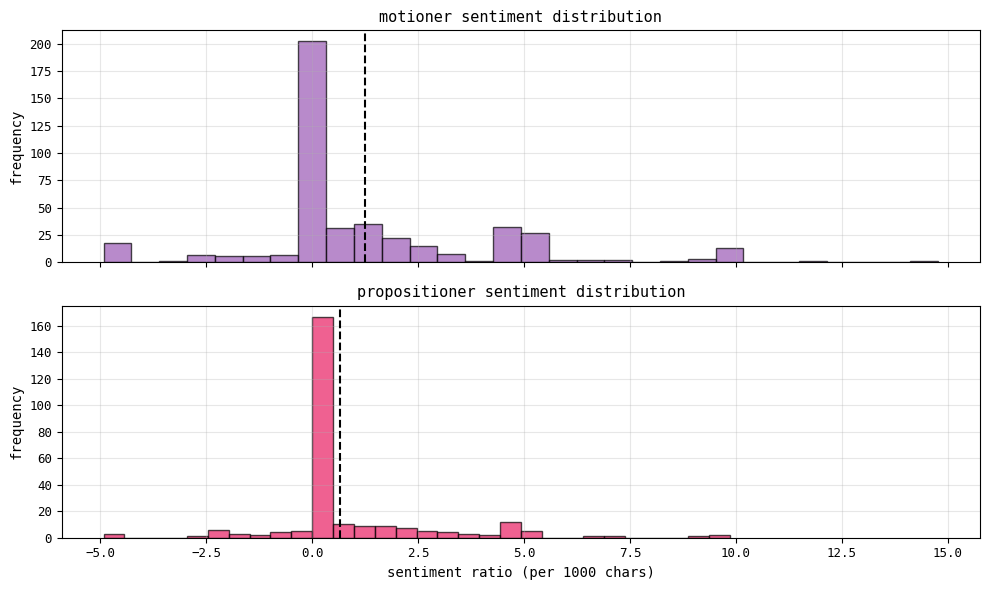

In [14]:
# histogram of sentiment score distributions
fig, axes = plt.subplots(2, 1, figsize=(10, 6), sharex=True)

# motioner
axes[0].hist(mot_data, bins=30, color=COLOUR_MOT, alpha=0.7, edgecolor='black')
axes[0].axvline(mot_data.mean(), color='black', linestyle='--', linewidth=1.5)
axes[0].set_ylabel('frequency')
axes[0].set_title('motioner sentiment distribution')
axes[0].grid(alpha=0.3)

# propositioner
axes[1].hist(prop_data, bins=30, color=COLOUR_PROP, alpha=0.7, edgecolor='black')
axes[1].axvline(prop_data.mean(), color='black', linestyle='--', linewidth=1.5)
axes[1].set_xlabel('sentiment ratio (per 1000 chars)')
axes[1].set_ylabel('frequency')
axes[1].set_title('propositioner sentiment distribution')
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.savefig('/Users/simon/Dropbox/wrk/active/research/riksdagen-data/swe-rd-ai/results/rq5_sentiment_histogram.png',
            dpi=300, bbox_inches='tight')
plt.show()

## Statistical comparison

In [15]:
# summary statistics by document type
summary_stats = df_with_ai.groupby('doc_type').agg({
    'sentiment_ratio': ['mean', 'median', 'std', 'count'],
    'positive_count': 'mean',
    'negative_count': 'mean'
}).round(3)

print("sentiment statistics by document type:")
print(summary_stats)

sentiment statistics by document type:
         sentiment_ratio                     positive_count negative_count
                    mean median    std count           mean           mean
doc_type                                                                  
mot                1.251    0.0  2.882   443          2.494          0.980
prop               0.667    0.0  1.917   262          1.672          0.504


In [16]:
# mann-whitney u test for difference in sentiment distributions
statistic, p_value = stats.mannwhitneyu(mot_data, prop_data, alternative='two-sided')

print(f"\nmann-whitney u test:")
print(f"  statistic: {statistic:.2f}")
print(f"  p-value: {p_value:.4f}")
print(f"  significant at α=0.05: {p_value < 0.05}")


mann-whitney u test:
  statistic: 66331.50
  p-value: 0.0007
  significant at α=0.05: True


In [17]:
# effect size (cohen's d)
mean_diff = mot_data.mean() - prop_data.mean()
pooled_std = np.sqrt((mot_data.std()**2 + prop_data.std()**2) / 2)
cohens_d = mean_diff / pooled_std

print(f"\neffect size (cohen's d): {cohens_d:.3f}")
if abs(cohens_d) < 0.2:
    effect = 'negligible'
elif abs(cohens_d) < 0.5:
    effect = 'small'
elif abs(cohens_d) < 0.8:
    effect = 'medium'
else:
    effect = 'large'
print(f"  interpretation: {effect}")


effect size (cohen's d): 0.238
  interpretation: small


## Export results

In [18]:
# prepare export data
export_df = df_with_ai[[
    'doc_id', 'doc_type', 'parl_year', 'title',
    'context_count', 'positive_count', 'negative_count',
    'context_length', 'sentiment_ratio'
]].copy()

# save to csv
output_path = Path('/Users/simon/Dropbox/wrk/active/research/riksdagen-data/swe-rd-ai/results/rq5_sentiment.csv')
export_df.to_csv(output_path, index=False, encoding='utf-8')

print(f"results exported to {output_path}")
print(f"total documents: {len(export_df)}")

results exported to /Users/simon/Dropbox/wrk/active/research/riksdagen-data/swe-rd-ai/results/rq5_sentiment.csv
total documents: 705


In [19]:
# export temporal summary
temporal_output = Path('/Users/simon/Dropbox/wrk/active/research/riksdagen-data/swe-rd-ai/results/rq5_sentiment_temporal.csv')
temporal_sentiment.to_csv(temporal_output, index=False, encoding='utf-8')

print(f"temporal summary exported to {temporal_output}")

temporal summary exported to /Users/simon/Dropbox/wrk/active/research/riksdagen-data/swe-rd-ai/results/rq5_sentiment_temporal.csv
